분류가 아닌 회귀로 풀어야하는지,

풀고나서 라벨링 데이터에 맞추어 볼때, groupby('id')를 사용하고 테스트를 진행했어야하는지

# 헬스케어 웨어러블 기반 치매 고위험군 병리진단으로 정의된 치매진행 라이프로그 학습용 데이터 

(광주광역시)

연구대상자 : 광주광역시 내 거주자 300명 (정상:150명, 치매 위험군: 150명)

50대: 4명, 60대: 63명, 70대: 193명, 80대이상:40명

남자: 137명, 여자: 163명

*샘플데이터 16명에대한 정보

필요성:
- 고령화 사회로의 진입 및 치매 발병률 증가에 따른 의료비 부담 증가로 인해 치매 환자의 조기진단과 치료가 중요한 과제로 부상
- 치매조기진단 예측 및 발병의 예방과 선제적 관리를 위한 AI 기술개을 위하여 검증된 학습용 데이터를 구축하고자 함

중요 칼럼:
- activity_score: 활동점수
- sleep_score: 수면점수
- TOTAL: 총점

진단결과:
- CN: 정상
- MCI: 경도인지장애
- Dem: 치매


## 머신러닝 프로세스
Wrangling한 데이터를 train_test_split 후, 검증데이터를 통해 Ensemble모델인 RandomForestClassifier를 사용하여 모델의 평가지표를 측정한다.

측정한 데이터를 라벨링데이터에 맞추어 비교한다.
- 라벨링데이터: id별로 치매의 정도를 나타내고 있다.
- 데이터들을 종합하여 groupby로 묶은 후 평가

In [65]:
!pip install category_encoders

     |████████████████████████████████| 86 kB 2.9 MB/s 


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [101]:
activity = pd.read_csv('/content/drive/MyDrive/dataset/2020-02-128.치매고위험군_sample/원천데이터/1.걸음거리/sample_activity.csv')
sleep = pd.read_csv('/content/drive/MyDrive/dataset/2020-02-128.치매고위험군_sample/원천데이터/2.수면/sample_sleep.csv')
mmse = pd.read_csv('/content/drive/MyDrive/dataset/2020-02-128.치매고위험군_sample/원천데이터/3.인지기능/sample_mmse.csv')

In [102]:
mmse

,SAMPLE_EMAIL,DIAG_SEQ,DIAG_NM,DOCTOR_NM,MMSE_NUM,MMSE_KIND,Q01,Q02,Q03,Q04,...,Q14_1,Q14_2,Q15,Q16_1,Q16_2,Q16_3,Q17,Q18,Q19,TOTAL
0,nia+041@rowan.kr,3,CN,-,3,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,29
1,nia+118@rowan.kr,4,CN,-,4,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,30
2,nia+141@rowan.kr,3,CN,-,3,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,30
3,nia+279@rowan.kr,1,MCI,-,1,2,1,2,2,1,...,2,2,1,1,2,2,1,2,2,17
4,nia+252@rowan.kr,3,MCI,-,4,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,27
5,nia+106@rowan.kr,4,MCI,-,4,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,28
6,nia+343@rowan.kr,4,CN,-,4,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,28
7,nia+188@rowan.kr,3,CN,-,3,2,2,2,2,2,...,2,2,2,1,2,2,2,2,2,27
8,nia+144@rowan.kr,2,MCI,-,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,29
9,nia+088@rowan.kr,4,MCI,-,4,2,2,2,2,2,...,2,2,2,1,2,2,2,2,2,28


In [10]:
def undergo(data):
  # replace
  data.columns = data.columns.str.lower()
  data.columns = data.columns.str.replace('sleep_','')
  data.columns = data.columns.str.replace('activity_','')
  
  # split
  data[['id','domain']] = data['email'].str.split('@', expand=True)
  data[['nia','id']]  = data['id'].str.split('+',expand=True)
  
  # drop
  data.drop(columns=['nia','email','domain'],axis=1, inplace=True)
  data.drop((x for x in data.columns if ('convert' in x or '5min' in x or 'met_min' in x or 'day' in x)),axis=1,inplace=True)
  
  # sequence
  #col_list = ['id','score','total']
  #data=data[col_list]
  return data

go_act = undergo(activity)
go_sleep = undergo(sleep)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


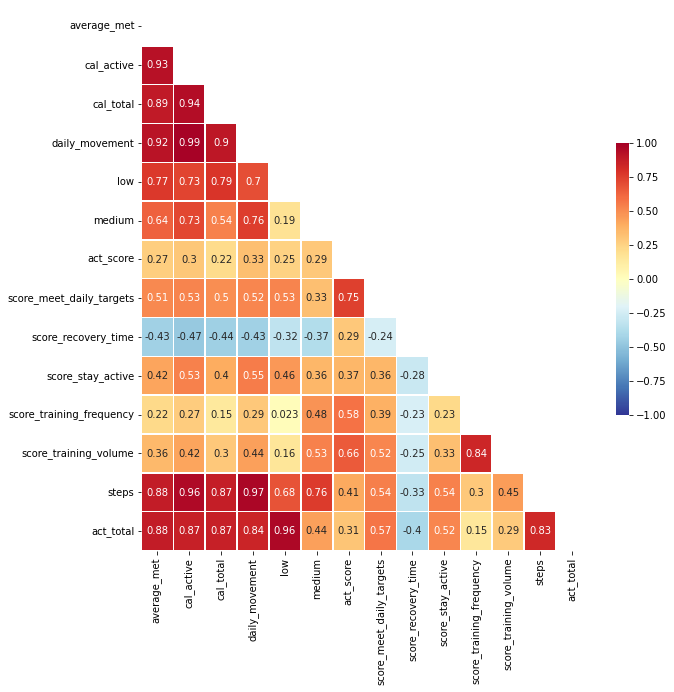

In [61]:
fig, ax = plt.subplots( figsize=(10,10) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(go_act.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(go_act.corr(), 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show();

In [14]:
drop_cols =['high','inactive','inalerts','non_wear','rest','score_move_every_hour']
go_act.drop(drop_cols,axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


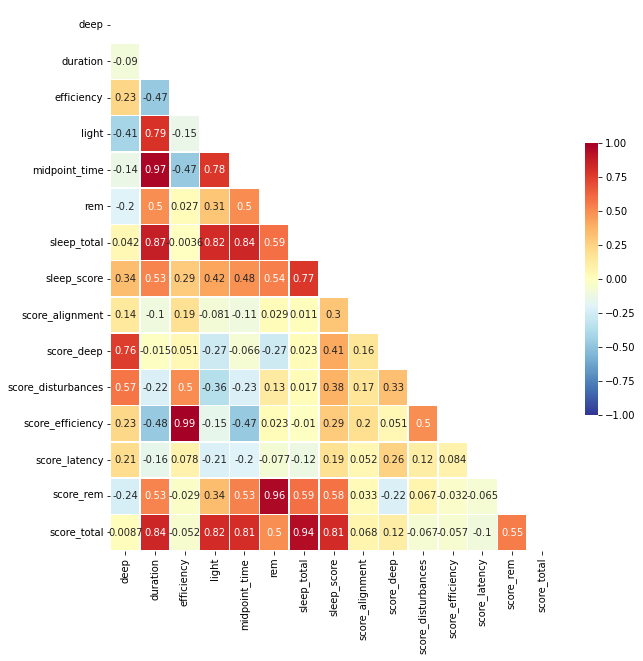

In [62]:
fig, ax = plt.subplots( figsize=(10,10) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(go_sleep.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(go_sleep.corr(), 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show();

In [17]:
save_cols = ['deep','duration','efficiency','light','midpoint_time','rem','total']
score_cols = [x for x in go_sleep.columns if 'score' in x]
sleep_cols = save_cols + score_cols
go_sleep = pd.DataFrame(go_sleep,columns=sleep_cols)

In [58]:
mmse = pd.DataFrame(mmse,columns=('SAMPLE_EMAIL','TOTAL'))

In [77]:
def undergone(df):
  # replace
  df.columns = df.columns.str.lower()
  df.columns = df.columns.str.replace('sample_','')
  df.columns = df.columns.str.replace('total','mmse_total')

  # split
  df[['id','domain']] = df['email'].str.split('@', expand=True)
  df[['nia','id']]  = df['id'].str.split('+',expand=True)

  # drop
  df.drop(columns= ['email','domain','nia'],axis=1,inplace=True)
  df= ['id','mmse_total']
  return df

go_mmse = undergone(mmse)

KeyError: ignored

In [98]:
go_mmse.loc[15,axis=1]

SyntaxError: ignored

In [40]:
go_sleep.rename(columns={'total':'sleep_total', 'score':'sleep_score'},inplace=True)
go_act.rename(columns={'total':'act_total', 'score':'act_score'},inplace=True)

In [41]:
go_df = pd.concat([go_sleep, go_act], axis=1)

In [ ]:
go_df.isnull().sum(), go_df.describe()

In [121]:
# 각 실험자들의 평균 점수
go_df.groupby('id')['act_score'].agg('mean') + go_df.groupby('id')['sleep_score'].agg('mean') + go_mmse

id
016    189.955224
041    196.916667
067    161.186667
088    154.119048
106    178.945055
118    192.790323
141    206.623188
144    181.277778
181    174.209677
188    196.615385
252    173.625000
268    189.807018
279    158.218750
343    196.467742
354    180.122807
438    190.860465
dtype: float64

In [122]:
go_df

,deep,duration,efficiency,light,midpoint_time,rem,sleep_total,sleep_score,score_alignment,score_deep,...,medium,act_score,score_meet_daily_targets,score_recovery_time,score_stay_active,score_training_frequency,score_training_volume,steps,act_total,id
0,10110,37920,77,15330,17820,3780,29220,84,87,100,...,6,87,78,100,54,100,97,4212,207,279
1,7440,28680,77,11820,12990,2850,22110,75,100,98,...,9,83,60,100,58,96,96,3306,140,279
2,4620,32040,67,12360,18390,4530,21510,68,100,94,...,6,73,43,100,55,71,83,2550,131,279
3,7440,25440,84,9060,12480,4860,21360,77,100,98,...,5,70,43,100,58,71,59,4009,208,279
4,4320,20700,65,7470,9870,1740,13530,52,80,88,...,6,70,43,100,89,40,46,8081,517,279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,720,25080,82,16110,13350,3690,20520,61,100,14,...,59,93,100,98,87,100,99,14113,548,144
996,870,20580,86,12390,10530,4530,17790,59,93,17,...,58,96,100,98,77,100,100,13704,463,144
997,1020,17160,69,7560,9180,3240,11820,42,85,19,...,73,98,100,95,97,100,100,14244,486,144
998,300,39120,85,23430,18300,9660,33390,81,100,6,...,69,94,100,89,85,100,100,13199,451,144


In [120]:
go_mmse

id
041    29
118    30
141    30
279    17
252    27
106    28
343    28
188    27
144    29
088    28
016    28
268    26
438    27
181    26
354    26
067    16
Name: mmse_mmse_total, dtype: int64

In [46]:
go_df.nunique().sort_values(ascending=False) # high cardinality 존재하나 continuos한 데이터 
go_df.drop('met_1min',axis=1,inplace=True) # 신호column 삭제
go_df.columns.duplicated().sum() # 중복된 이름의 column 없음

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


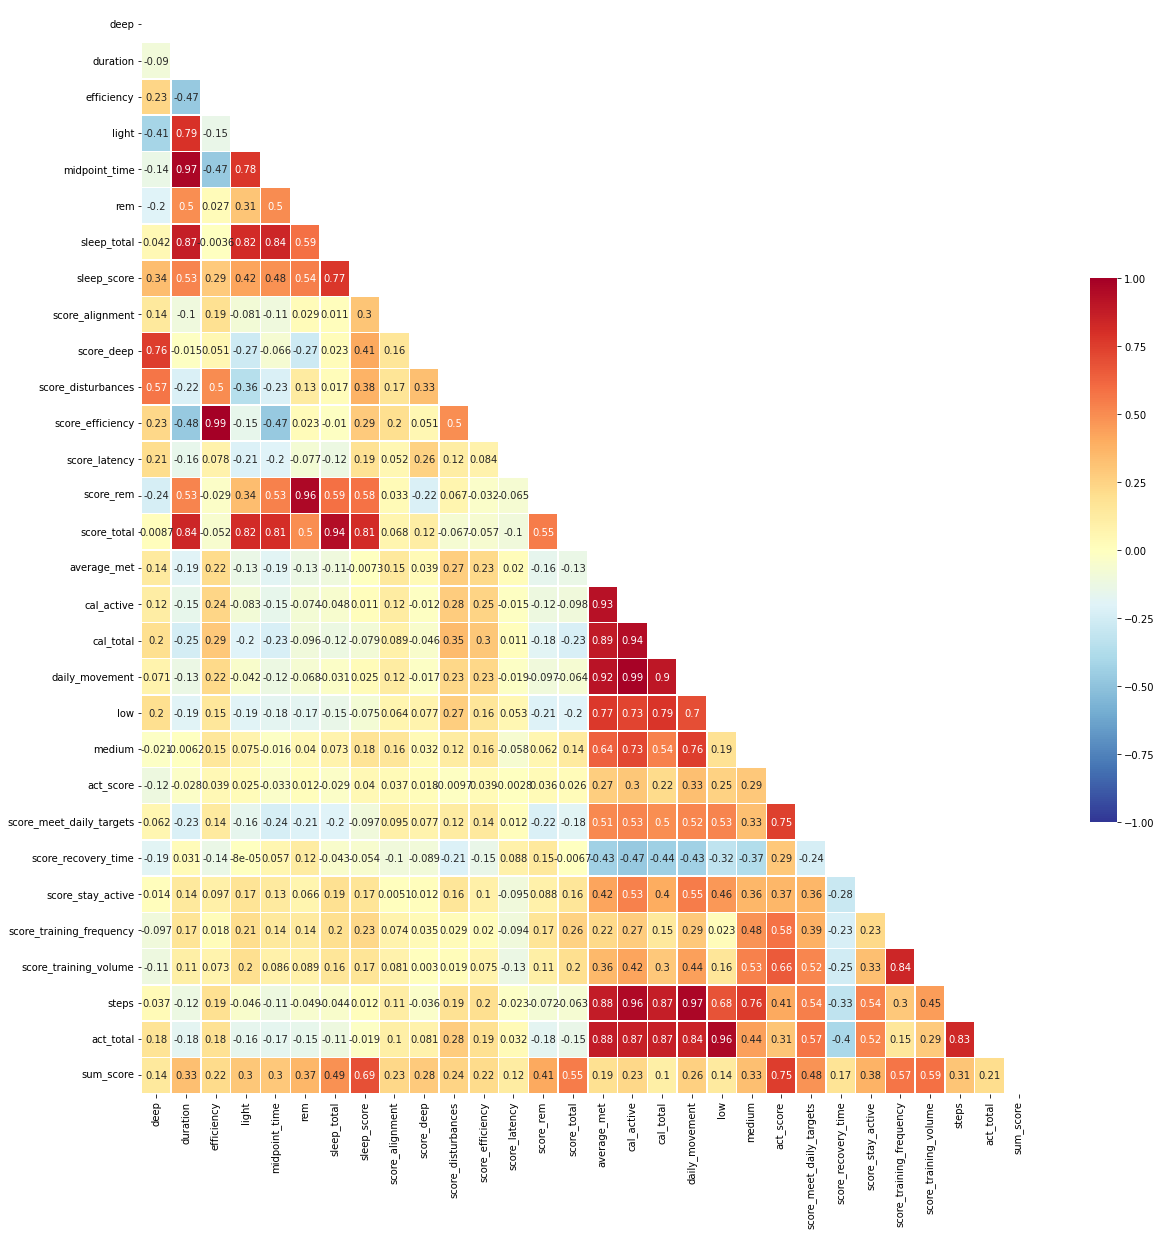

In [150]:
fig, ax = plt.subplots( figsize=(20,20) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(go_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(go_df.corr(), 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show();

In [145]:
go_df['sum_score'] = go_df['act_score'] + go_df['sleep_score']
go_df.columns

Index(['deep', 'duration', 'efficiency', 'light', 'midpoint_time', 'rem',
       'sleep_total', 'sleep_score', 'score_alignment', 'score_deep',
       'score_disturbances', 'score_efficiency', 'score_latency', 'score_rem',
       'score_total', 'average_met', 'cal_active', 'cal_total',
       'daily_movement', 'low', 'medium', 'act_score',
       'score_meet_daily_targets', 'score_recovery_time', 'score_stay_active',
       'score_training_frequency', 'score_training_volume', 'steps',
       'act_total', 'id', 'sum_score'],
      dtype='object')

In [146]:
target = 'sum_score'

train, test = train_test_split(go_df, train_size=0.80, test_size=0.20, random_state=42)
train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=42)

features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [155]:
pipe = make_pipeline(
    OrdinalEncoder()
    , SimpleImputer()
    , RandomForestClassifier(random_state=42, n_jobs=-1)
    )


dists = {
      'simpleimputer__strategy': ['mean','most_frequent']
    , 'randomforestclassifier__n_estimators': randint(100, 500)
    , 'randomforestclassifier__criterion': ['entropy']
    , 'randomforestclassifier__max_depth': [5,10,15,20,None]
    , 'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample']
    , 'randomforestclassifier__max_features': ['sqrt', 'log2']
}


clf = RandomizedSearchCV(
      pipe
    , param_distributions=dists
    , n_iter=5
    , cv=10
    , scoring='f1'
    , verbose=1
    , n_jobs=-1

)

clf.fit(X_train, y_train);

Fitting 10 folds for each of 5 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


In [156]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('f1 score: ', clf.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__class_weight': 'balanced_subsample', 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 173, 'simpleimputer__strategy': 'most_frequent'}
f1 score:  0.103125


In [149]:
pipe = clf.best_estimator_
y_pred = pipe.predict(X_test)

In [163]:
y_pred.shape

(200,)

In [166]:
clf.score(y_pred, y_test)

ValueError: ignored